# Codebase for "A Dynamic Theory of Deterrence and Compliance"

Format: JupyterLab Notebook

Kernel: Python3

Code for all results and figures. 

*Note, to use this file user must first set the local path to store results of computation.*

In [18]:
""" 
    import libraries and set display options 
"""
import sys
import random as rn
import numpy as np
import math as math
import quantecon as qe
import scipy.stats as stats
import matplotlib.pyplot as plt

from numba import jit
from scipy.stats import norm
from scipy.stats import binom
from scipy.stats import truncnorm
from scipy.stats import entropy
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition


path = 

# aesthetic settings
import warnings
sys.setswitchinterval(1500)
warnings.filterwarnings('ignore')
%matplotlib inline

### Main Functions Called

The following cell contains the main functions called in the main codebase. 

In [19]:
""" 
    functions used by simulations 
"""

# apprehension function, min catch
@jit(nopython=True)
def Apprehend(v, R):
    γ = 0.80 
    if v == 0:
        prob_a = γ
    else:
        prob_a = γ*min(1, R/v)
    return prob_a

# apprehension function, exponential
@jit(nopython=True)
def Apprehend_exp(v, R):
    γ = 0.80  
    ϵ = 4
    if v == 0:
        prob_a = γ
    else:
        prob_a = γ*(1-(1/pow(ϵ,(R/v))))
    return prob_a

# create a 'criminal opportunity'
def Opportunity():
    lower, upper = 0, 1
    ḡ , σ = 0.6, 0.2
    return max(0, np.random.normal(ḡ, σ)) 

# create a distribution of 'criminal opportunities'
@jit(nopython=True)
def Criminal_opps(μ, σ, agents, T):
    g = np.zeros((T,agents))
    for i in range(T):
        g[i] = [max(0, np.random.normal(ḡ, σ)) for agent in range(agents)]
    return g

# create a distribution of 'criminal opportunities'
@jit(nopython=True)
def Criminal_opps_uniform(μ, σ, agents, T):
    g = np.zeros((T,agents))
    for i in range(T):
        g[i] = [max(0, np.random.uniform(0, 1.2)) for agent in range(agents)]
    return g

def Simulation(criminal_opps, R, F, Z):
# agent priors
    α,β = 1, 0.25
    init_period = 100
# tracking arrays for endogenous variables of interest
    a_t,v_t, g_t = [], [], []
# seed for priors
    append_v = v_t.append
    append_a = a_t.append
    append_g = g_t.append
    for t in range(Z):
        v = np.random.randint(1,agents)
        a = np.random.randint(0,v)
        append_v(v)
        append_a(a)
# main sim loop, starts at T = 500   
    for t in range(len(criminal_opps)):
        a,v,g = 0,0,0
        q = (α + np.sum(a_t[-Z:]))/(α + β + np.sum(v_t[-Z:]))
        for g_i in criminal_opps[t]:
            if  q <= g_i/F:
                v = v + 1
                g = g + g_i
        a = stats.binom.rvs(v, Apprehend(v, R))
        append_v(v)
        append_a(a)
        append_g(g)
    
    return np.array(v_t[init_period+Z:]), np.array(a_t[init_period+Z:]), np.array(g_t[init_period+Z:])

def Simulation_exp(criminal_opps, R, F, Z):
# agent priors
    α,β = 1, 0.25
    init_period = 100
# tracking arrays for endogenous variables of interest
    a_t,v_t, g_t = [], [], []
# seed for priors
    append_v = v_t.append
    append_a = a_t.append
    append_g = g_t.append
    for t in range(Z):
        v = np.random.randint(1,agents)
        a = np.random.randint(0,v)
        append_v(v)
        append_a(a)
# main sim loop, starts at T = 500   
    for t in range(len(criminal_opps)):
        a,v,g = 0,0,0
        q = (α + np.sum(a_t[-Z:]))/(α + β + np.sum(v_t[-Z:]))
        for g_i in criminal_opps[t]:
            if  q <= g_i/F:
                v = v + 1
                g = g + g_i
        a = stats.binom.rvs(v, Apprehend_exp(v, R))
        append_v(v)
        append_a(a)
        append_g(g)
    
    return np.array(v_t[init_period+Z:]), np.array(a_t[init_period+Z:]), np.array(g_t[init_period+Z:])

def Simulation_het_q(criminal_opps, R, F, Z):
# agent priors
    α,β = 1, 0.25
    init_period = 100
# tracking arrays for endogenous variables of interest
    a_t,v_t, g_t = [], [], []
# seed for priors
    append_v = v_t.append
    append_a = a_t.append
    append_g = g_t.append
    for t in range(Z):
        v = np.random.randint(1,agents)
        a = np.random.randint(0,v)
        append_v(v)
        append_a(a)
# main sim loop, starts at T = 500   
    for t in range(len(criminal_opps)):
        a,v,g = 0,0,0
        q = (α + np.sum(a_t[-Z:]))/(α + β + np.sum(v_t[-Z:]))
        for g_i in criminal_opps[t]:
            q_i = q + np.random.uniform(-0.2,0.2)
            if q_i > 1:
                q_i = 1
            if q_i < 0:
                q_i = 0
            if  q_i <= g_i/F:
                v = v + 1
                g = g + g_i
        a = stats.binom.rvs(v, Apprehend(v, R))
        append_v(v)
        append_a(a)
        append_g(g)
    
    return np.array(v_t[init_period+Z:]), np.array(a_t[init_period+Z:]), np.array(g_t[init_period+Z:])

def Crackdown(criminal_opps, BE, RGB, RBB, F, Z):
# agent priors
    T = len(criminal_opps)
    α,β = 1, 0.25
    r = RGB
# tracking arrays for endogenous variables of interest
    a_t,v_t, g_t, r_t = [], [], [],[]
# seed for priors
    append_v = v_t.append
    append_a = a_t.append
    append_g = g_t.append
    append_r = r_t.append
    for t in range(Z):
        v = np.random.randint(1,agents)
        a = stats.binom.rvs(v, Apprehend(v, r))
        append_v(v)
        append_a(a)
        append_r(r)
# main sim loop, starts at T = 500   
    for t in range(len(criminal_opps)):
        if t > 0:
            if v >= BE:
                r = RBB
            else:
                r = RGB 
        else:
            r = RGB
        a,v,g = 0,0,0
        q = (α + np.sum(a_t[-Z:]))/(α + β + np.sum(v_t[-Z:]))
        for g_i in criminal_opps[t]:
            if  q <= g_i/F:
                v = v + 1
                g = g + g_i
        a = stats.binom.rvs(v, Apprehend(v, r))
        append_v(v)
        append_a(a)
        append_g(g)
        append_r(r)
    
    return np.array(v_t[-T:]), np.array(a_t[-T:]), np.array(g_t[-T:]), np.array(r_t[-T:])

# State Space Production and Transition Matrices

The first function produces, for a given number of agents, the State Space of the model ($\boldsymbol{Z}$) from Section 2.3.

The second function produces the conditional probabilities establishing Proposition 3 on page 11.

The third function takes the probabilities from above as arguments and produces the complete transition matrix for the model ($\boldsymbol{T}$ from page 9).

In [21]:
"""
    Produce State space
        parameters: agents
        returns: S, Shat, s
"""
def State_space(agents: int):
    w = np.sum(np.arange(1,agents+2))
    s = np.zeros(w, dtype=int)
    R̂ = np.empty(w, dtype=object)
    Ŝ = np.empty(w, dtype=object)
    S = [[(i,j) for j in range(agents+1)] for i in range(agents+1)]
    l=0

    for i in range(agents+1):
        for j in range(agents+1):
            if i >= j:
                k = np.arange(i+1)
                S[i][j] = (i,j)
                Ŝ[l] = (1+i-j+np.sum(k),i,j)
                s[l] = 1+i-j+np.sum(k)
                l=l+1
            if i < j:
                S[i][j] = (i,0)
    Ŝ = sorted(Ŝ, key=lambda tup: tup[0])
    s = sorted(s)
    return S, Ŝ, s

"""
    Produce M1 and M2 matrices to speed analysis
        parameters: agents, F
        returns: M1, M2
"""

def TM_matrices(agents: int, F:float):
# parameters
    ḡ = 0.60
    σ = 0.20
    α,β = 1,0.25
# tracking arrays/vectors
    S, Ŝ, s = State_space(agents)
    w = len(s)
    A = np.zeros(w)
    π = np.zeros(w)
    M1 = np.zeros((w,w))
    M2 = np.zeros((w,w))
    
# main loop
    for state_1 in range(w):
        v = Ŝ[state_1][1]
        a = Ŝ[state_1][2]
        q = (α + a)/(α + β + v)
        π[state_1] = 1 - norm.cdf(F*q-ḡ,0,σ)
        for state_2 in range(w):
            v = Ŝ[state_2][1]
            a = Ŝ[state_2][2]
            v̂ = math.factorial(v)
            â = math.factorial(a)
            d̂ = math.factorial(v-a)
            M1[state_1,state_2] = binom.pmf(v,agents,π[state_1])
            M2[state_1,state_2] = v̂/(â*d̂)
    return M1, M2

""" 
    Produce transition matrix for all s to s'
        s = numbered states
"""
def Transition_matrix(agents: int, M1, M2, R: int, F:float, switch:bool):
# tracking arrays/vectors
    S, Ŝ, s = State_space(agents)
    w = len(s)
    T̂ = np.zeros((w,w))
    
# main loop
    for state_1 in range(w):
        for state_2 in range(w):
            v = Ŝ[state_2][1]  
            a = Ŝ[state_2][2]
            d = v - a
            if switch:
                Â = Apprehend(v, R[state_1])
            else:
                Â = Apprehend(v, R[state_1])
            M3 = math.pow(Â, a)*math.pow(1-Â, d)
            T̂[state_1,state_2] = M1[state_1,state_2]*M2[state_1,state_2]*M3
    return T̂

def Compute_cost(agents: int, R:int , F:float):
# parameters
    δ, λ = 2, 5
    ḡ = 0.60
    σ = 0.20
    α,β = 1,0.25
# tracking arrays/vectors
    S, Ŝ, s = State_space(agents)
    w = len(s)
    A = np.zeros(w)
    π = np.zeros(w)
    Ĉ = np.zeros(w)
    
# main loop
    for state in range(w):
        v = Ŝ[state][1]
        a = Ŝ[state][2]
        q = (α + a)/(α + β + v)
        π[state] = 1 - norm.cdf(F*q-ḡ, 0, σ)
        A[state] = Apprehend(π[state]*agents, R[state])
        Ĉ[state] = δ*R[state] + (λ-1)*agents*π[state] + agents*F*π[state]*A[state]
    return Ĉ  

In [22]:
""" 
    baseline model parameters for kernel
    
"""
# main parameters
agents = 100
Z = 1, 2

# distribution parameters
ḡ , σ = 0.6 , 0.2

# Bayesian priors
α, β = 1, 0.25

# costs
ρ, λ = 2 , 5

# domain of analysis for policy
F = 1
R_low, R_high = 0, agents+1

# benchmarking parameters
block = 50000
checks, C = 5, 0.01

### Table A.1

First cell produces the transition matrix of the finite regular Markov chain. Using the TM we produce the associated Markov chain (MC) and its associated stationary distribution ($\bar{S}$).

The following cell produces the results from Table A.1 by comparing the estimated distribution of violations ($\boldsymbol{\hat{D}}$) against $\bar{S}$.

In [23]:
""" 
    produce TM and SD in order to benchmark simulation
            state space for:
                    N = 50, Z=1
"""
# paramaters for benchmarking exercise
switch = True
agents, Z = 50, 1
R_low, R_high = 0, agents+1
# variables used for benchmark exercise
R = np.ones(np.sum(np.arange(1,agents+2)), dtype=int)

# "control" variables
ex_v = np.zeros(R_high-R_low)
ex_a = np.zeros(R_high-R_low)
std_v = np.zeros(R_high-R_low)
# vectors, arrays, storage objects
S̄ = np.empty(R_high-R_low, dtype=object)
V̂ = np.empty(R_high-R_low, dtype=object)
Â = np.empty(R_high-R_low, dtype=object)
Ĉ = np.empty(R_high-R_low, dtype=object)
MC = np.empty(R_high-R_low, dtype=object)

# create the ordered state space
S, Ŝ, s = State_space(agents)
max_v = np.zeros(len(s))
max_a = np.zeros(len(s))
for state in range(len(s)):
    max_v[state] = Ŝ[state][1]
    max_a[state] = Ŝ[state][2]

# create transition matrices
M1 , M2 = TM_matrices(agents, F)

# main loop
for r in range(R_low, R_high):
    index = 0
    a, v = 0, 0
    R.fill(r)
    TM = Transition_matrix(agents, M1, M2, R, F, switch)
    MC[r] = qe.MarkovChain(TM)
    S̄[r] = MC[r].stationary_distributions
    V̂[r] = S̄[r]*max_v
    Â[r] = S̄[r]*max_a
    ex_v[r] = np.sum(V̂[r])
    ex_a[r] = np.sum(Â[r])
    std_v[r] = np.std(V̂[r])

In [24]:
"""
        Benchmarking: Run simulation to converge for comparison with results from cell above
                        
                        Note: need to set r = 5, 21, 45 to reproduce Table A.1
"""
runs, block = 1000, 50000
agents = 50
Z = 1
r = 45
C, checks = 0.01, 5
TEST = np.zeros(runs)

# translate SD from TM into same format as DD1
#      DD1 runs from 0 to agents+1
#      state space of SD is much larger
DD3 = np.zeros(agents+1)
for i in Ŝ:
    DD3[i[1]] = DD3[i[1]] + S̄[r][0][i[0]-1]

time_to_converge = 0
for run in range(runs):
    v_μ = 0
    converged, passed = False, 0
    DD1 = np.zeros(agents+1)
    DD2 = np.zeros(agents+1)
    criminal_opps = Criminal_opps(ḡ,σ,agents,block)
    v_t, a_t, g_t = Simulation(criminal_opps,r,F,Z)
    v, a, g = 0, 0, 0
    v = np.append(v, v_t)
    a = np.append(a, a_t)
    g = np.append(g, g_t)
    for i in v:
        DD1[i] = DD1[i] + 1
    while not converged:
        time_to_converge = time_to_converge + 1
        criminal_opps = Criminal_opps(ḡ,σ,agents,block)
        v_t, a_t, g_t = Simulation(criminal_opps,r,F,Z)
        v = np.append(v, v_t)
        a = np.append(a, a_t)
        g = np.append(g, g_t)
        for i in v:
            DD2[i] = DD2[i] + 1    
        if np.abs(np.sum((DD2/np.sum(DD2)) - (DD1/np.sum(DD1)))) < C:
            passed = passed + 1
            if passed > checks:
                converged = True
        DD1 = DD2[:]
    DD1 = DD1/np.sum(DD1)
    TEST[run] = np.sum(np.abs(DD1-DD3))
    
    
np.set_printoptions(precision=4)
x = np.mean(TEST)
y = np.std(TEST)
z = np.max(TEST)

print("%0.4f" % x),print("%0.4f" % y),print("%0.4f" % z),print("%0.4f" % ((time_to_converge+1)/1000))

## Figure A.1:  Summarizing full information static model

In [7]:
"""
    compute number of expected equilibria as a function of v
"""
agents = 100

prob_eq = np.zeros((agents+1,agents+1))
ex_eq_v = np.zeros(agents+1)
ex_eq_good = np.zeros(agents+1)
ex_eq_bad = np.zeros(agents+1)
ex_eq_other = np.zeros(agents+1)

for R in range(agents+1):
    for v in range(agents+1):
        N = math.factorial(agents)/(math.factorial(v)*math.factorial(agents-v))
        A1 = 1 - (norm.cdf(Apprehend(v, R)*F,ḡ,σ))
        A2 = norm.cdf(Apprehend(v+1, R)*F,ḡ,σ)
        prob_eq[R][v] = N*math.pow(A1,v)*math.pow(A2,agents-v)
    ex_eq_good[R] = np.sum(prob_eq[R,:30])
    ex_eq_bad[R] = np.sum(prob_eq[R,70:])
    ex_eq_other[R] = np.sum(prob_eq[R,30:70])
    prob_norm = np.zeros(agents+1)
    prob_norm = prob_eq[R]/np.sum(prob_eq[R])
    ex_eq_v[R] = np.sum(prob_norm[0:30]*np.arange(30)*ex_eq_good[R])+ np.sum(prob_norm[31:70]*np.arange(31,70)*ex_eq_other[R])+np.sum(prob_norm[71:]*np.arange(71,101)*ex_eq_bad[R])
    
np.save(path+'fig31_prob_eq.npy', prob_eq)   
np.save(path+'fig31_ex_eq_v.npy', ex_eq_v)   
np.save(path+'fig31_ex_good.npy', ex_eq_good)
np.save(path+'fig31_ex_bad.npy', ex_eq_bad)
np.save(path+'fig31_ex_other.npy', ex_eq_other)

### Visualization

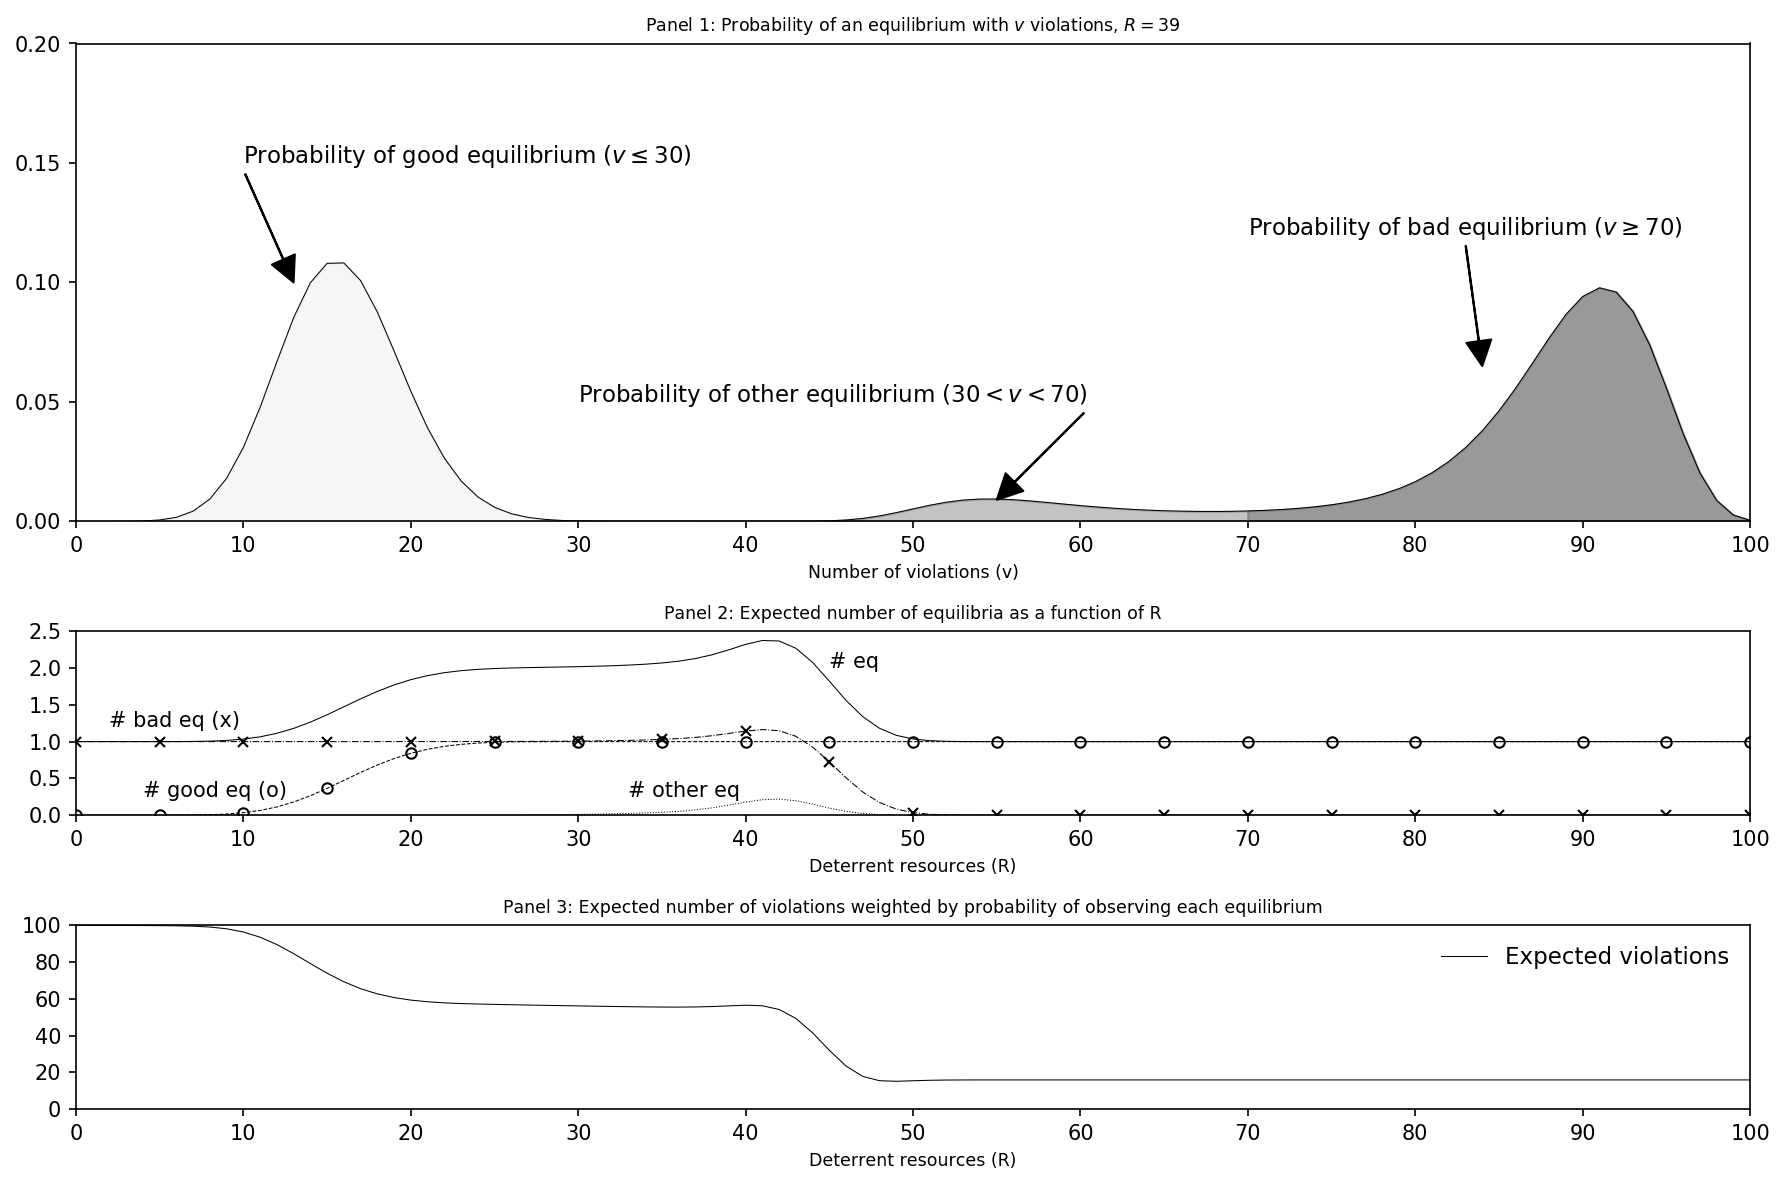

In [6]:
prob_eq = np.load(path+'fig31_prob_eq.npy')
ex_eq_v = np.load(path+'fig31_ex_eq_v.npy')
ex_eq_good = np.load(path+'fig31_ex_good.npy')
ex_eq_bad = np.load(path+'fig31_ex_bad.npy')
ex_eq_other = np.load(path+'fig31_ex_other.npy')
agents = len(prob_eq)-1

fig = plt.figure(figsize=(12,8),tight_layout=True,dpi=150)
x = np.arange(0,agents+1)
x1 = np.arange(0,30)
x2 = np.arange(70,agents+1)
x3 = np.arange(30,71)
gs = fig.add_gridspec(4, 1)
ax1 = fig.add_subplot(gs[:2, 0])
ax2 = fig.add_subplot(gs[2, 0])
ax3 = fig.add_subplot(gs[3, 0])

ax1.set_title('Panel 1: Probability of an equilibrium with $v$ violations, $R=39$', fontsize= 'small')
ax1.set_xlabel('Number of violations (v)', fontsize= 'small')
ax1.yaxis.label.set_size(11)
ax1.set_xticks(np.arange(0,agents+10,10))
ax1.set_yticks(np.arange(0, 0.25,.05))
ax1.set_xlim([0, agents])
ax1.set_ylim([0, 0.20])
ax1.plot(x, prob_eq[39], color='k', linestyle='solid',linewidth=0.5)
ax1.fill_between(x1, prob_eq[39,:30], color='lightgray', alpha=0.2)
ax1.fill_between(x3, prob_eq[39,30:71], color='dimgray', alpha=0.4)
ax1.fill_between(x2, prob_eq[39,70:], color='gray', alpha=0.8)
ax1.annotate('Probability of bad equilibrium ($v \geq 70$)', xy=(84, .065), xytext=(70, .12), fontsize=11,
            arrowprops=dict(facecolor='black', width=0.15, shrink=0.0005))
ax1.annotate('Probability of good equilibrium ($v \leq 30$)', xy=(13, .10), xytext=(10, .15), fontsize=11,
            arrowprops=dict(facecolor='black', width=0.15, shrink=0.0005))
ax1.annotate('Probability of other equilibrium ($30 < v < 70$)', xy=(55, .009), xytext=(30, .05), fontsize=11,
            arrowprops=dict(facecolor='black', width=0.15, shrink=0.0005))

ax2.set_title('Panel 2: Expected number of equilibria as a function of R', fontsize= 'small')
ax2.set_xlabel('Deterrent resources (R)', fontsize='small')
ax2.set_xticks(np.arange(0,agents+10,10))
ax2.set_xlim([0, agents])
ax2.set_yticks(np.arange(0,2.75, 0.5))
ax2.set_ylim([0,2.5])
ax2.plot(x, ex_eq_good+ex_eq_bad+ex_eq_other, color='k', linestyle='solid',linewidth=0.5,  
         label='# of equilibria')
ax2.plot(x, ex_eq_good, color='k', linestyle='dashed',linewidth=0.5, marker="o", markevery=5, ms=5, markerfacecolor='none',
         label='# of good')
ax2.plot(x, ex_eq_bad, color='k', linestyle='dashdot',linewidth=0.5, marker="x", markevery=5, ms=5,
         label='# of bad')
ax2.plot(x, ex_eq_other, color='k', linestyle='dotted',linewidth=0.5,
         label='# of other')
ax2.annotate('# eq', xy=(45, 2.0), fontsize=10)
ax2.annotate('# good eq (o)', xy=(4, 0.25), fontsize=10)
ax2.annotate('# other eq', xy=(33, 0.25), fontsize=10)
ax2.annotate('# bad eq (x)', xy=(2, 1.2), fontsize=10)

ax3.set_title('Panel 3: Expected number of violations weighted by probability of observing each equilibrium', fontsize= 'small')
ax3.set_xlabel('Deterrent resources (R)', fontsize='small')
ax3.set_xticks(np.arange(0,agents+10,10))
ax3.set_xlim([0, agents])
ax3.set_yticks(np.arange(0,agents+10, 20))
ax3.set_ylim([0,agents])
ax3.plot(x, ex_eq_v, color='k', linestyle='solid',linewidth=0.5, 
         label='Expected violations')
ax3.legend(loc='best', fontsize=11, frameon=False)

#plt.savefig(path+);

In [8]:
"""
    compute number of expected equilibria as a function of v
            Note: calculation done for v = 10, 35, 50
"""
agents = 100
e_v_10 = np.zeros(agents+1)
e_v_35 = np.zeros(agents+1)
e_v_50 = np.zeros(agents+1)

for v in range(agents+1):
    e_v_10[v] = agents*(1 - (norm.cdf(Apprehend(v, 10)*F,ḡ,σ)))
    e_v_35[v] = agents*(1 - (norm.cdf(Apprehend(v, 35)*F,ḡ,σ)))
    e_v_50[v] = agents*(1 - (norm.cdf(Apprehend(v, 50)*F,ḡ,σ)))

np.save(path+'fig32_e_v_10.npy', e_v_10)   
np.save(path+'fig32_e_v_35.npy', e_v_35)   
np.save(path+'fig32_e_v_50.npy', e_v_50)

### Visualization

In [ ]:
"""
    compute number of expected equilibria as a function of v
"""
e_v_10 = np.load(path+'fig32_e_v_10.npy')
e_v_35 = np.load(path+'fig32_e_v_35.npy')
e_v_50 = np.load(path+'fig32_e_v_50.npy')

agents = len(e_v_0)
x = np.arange(0,agents)
intersections_10 = []
intersections_35 = []
intersections_50 = []

# Find intersections

    if int(e_v_10[i]) == x[i]:
        intersections_10.append(i)
        
for i in range(len(e_v_35)):
    if int(e_v_35[i]) == x[i]:
        intersections_35.append(i)

for i in range(len(e_v_50)):
    if int(e_v_50[i]) == x[i]:
        intersections_50.append(i)

fig, ax1 = plt.subplots(figsize=(10,6),tight_layout=True,dpi=150)

ax1.set_xlabel('Number of violations ($v_t$)', fontsize= 'large')
ax1.set_ylabel('$E(v_{t+1}|v_t)$', fontsize= 'medium')
ax1.yaxis.label.set_size(11)
ax1.set_xticks(np.arange(0,agents+10, 10))
ax1.set_yticks(np.arange(0,agents+10,10))
ax1.set_xlim([0, agents])
ax1.set_ylim([0, agents])
ax1.vlines(intersections_10[0], ymin=0, ymax=x[intersections_10[0]], linestyle='dotted', linewidth=0.5)
ax1.vlines(intersections_35[0], ymin=0, ymax=x[intersections_35[0]], linestyle='dotted', linewidth=0.5)
ax1.vlines(intersections_35[1], ymin=0, ymax=x[intersections_35[1]], linestyle='dotted', linewidth=0.5)
ax1.vlines(intersections_35[2], ymin=0, ymax=x[intersections_35[2]], linestyle='dotted', linewidth=0.5)
ax1.text(8,90, '$E(v_{t+1}|v_t, R=10)$', fontsize=11)
ax1.text(45,80, '$E(v_{t+1}|v_t, R=35)$', fontsize=11)
ax1.text(65,40, '$E(v_{t+1}|v_t, R=50)$', fontsize=11)
ax1.text(15,1, '15', fontsize=11)
ax1.text(45,1, '45', fontsize=11)
ax1.text(90,1, '92', fontsize=11)
ax1.text(99,1, '99', fontsize=11)
ax1.plot(x, x, color='k', linestyle='solid',linewidth=0.5)
ax1.plot(x, e_v_10, color='k', linestyle='dashed',linewidth=0.5,
        label='$E(v_{t+1}|v_t, R=10)$')
ax1.plot(x, e_v_35, color='k', linestyle='dashed',linewidth=0.5,
        label='$E(v_{t+1}|v_t, R=35)$')
ax1.plot(x, e_v_50, color='k', linestyle='dashed',linewidth=0.5,
        label='$E(v_{t+1}|v_t, R=50)$')

#plt.savefig(path+);

## Fig 3.1: Raw time series of violations for chosen values of R. [5x2 panels] 

Note, choosen values of R: 37, 40, 41, 42, 46

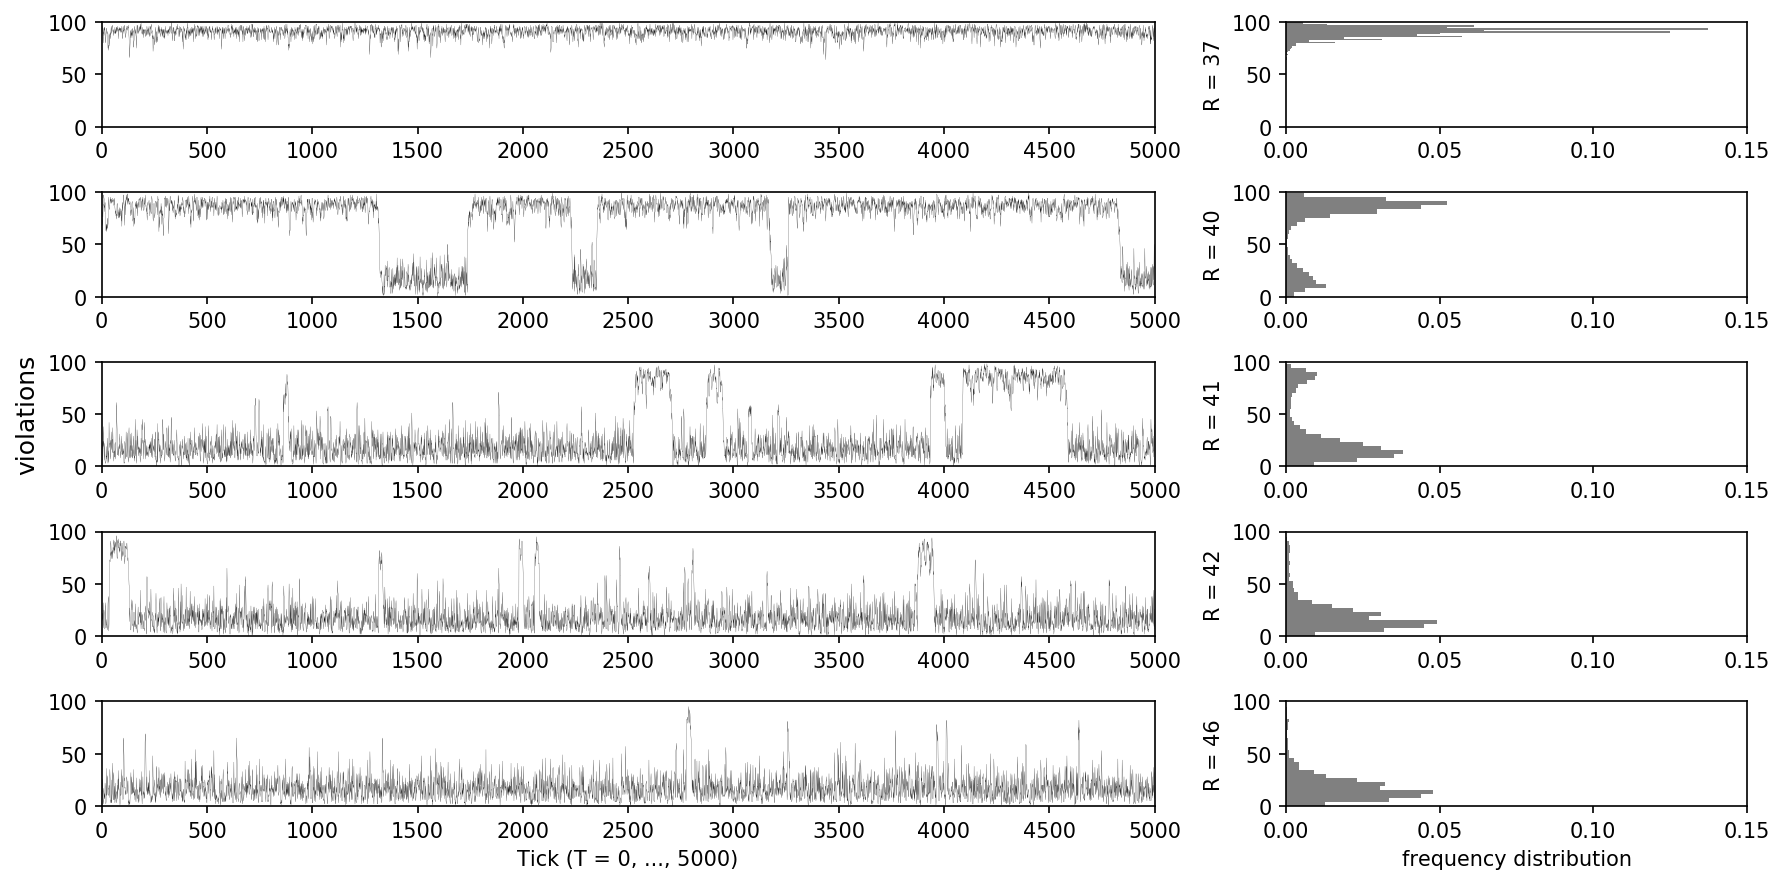

In [113]:
"""
        Fig 3.1: time path of 'raw data'
            Note: Set T = block for plotting purposes
"""
agents, Z = 100, 2

fig = plt.figure(figsize=(12,6),tight_layout=True,dpi=150)
gs = fig.add_gridspec(5, 3)
ax1 = fig.add_subplot(gs[0, :-1])
ax2 = fig.add_subplot(gs[1, :-1])
ax3 = fig.add_subplot(gs[2, :-1])
ax4 = fig.add_subplot(gs[3, :-1])
ax5 = fig.add_subplot(gs[4, :-1])
iax1 = fig.add_subplot(gs[0, -1])
iax2 = fig.add_subplot(gs[1, -1])
iax3 = fig.add_subplot(gs[2, -1])
iax4 = fig.add_subplot(gs[3, -1])
iax5 = fig.add_subplot(gs[4, -1])

illustrative_run = Criminal_opps(ḡ, σ, agents, 6000)
v, a, g, q = Simulation(illustrative_run,37,F,Z)
ax1.set_xlim([0, 5000])
ax1.set_ylim([0, agents])
ax1.set_xticks(np.arange(0, 5000+250, 500))
ax1.plot(v[500:6000],color='k',linewidth=0.10, label="violations")
plt.xticks(np.arange(0, agents))
plt.xlim(0,agents)
iax1.set_xlim([0, 0.15])
iax1.set_ylim([0,agents])
iax1.set_xticks(np.arange(0,0.20,0.05))
iax1.set(ylabel='R = 37')
iax1.yaxis.label.set_size(10)
iax1.hist(v[1000:6000], color='gray', orientation ='horizontal', density=True, lw=0, bins=25)

illustrative_run = Criminal_opps(ḡ, σ, agents, 6000)
v, a, g, q = Simulation(illustrative_run,40,F,Z)
ax2.set_xlim([0, 5000])
ax2.set_ylim([0, agents])
ax2.set_xticks(np.arange(0, 5000+500, 500))
ax2.plot(v[500:6000],color='k',linewidth=0.10, label="violations")
plt.xticks(np.arange(0, agents))
plt.xlim(0,agents)
iax2.set_xlim([0, 0.15])
iax2.set_ylim([0,agents])
iax2.set_xticks(np.arange(0,0.20,0.05))
iax2.set(ylabel='R = 40')
iax2.yaxis.label.set_size(10)
iax2.hist(v[1000:6000], color='gray', orientation ='horizontal', density=True, lw=0, bins=25)

illustrative_run = Criminal_opps(ḡ, σ, agents, 6000)
v, a, g, q = Simulation(illustrative_run,41,F,Z)
ax3.set(ylabel='violations')
ax3.yaxis.label.set_size(12)
ax3.set_xlim([0, 5000])
ax3.set_ylim([0, agents])
ax3.set_xticks(np.arange(0, 5000+250, 500))
ax3.plot(v[500:6000],color='k',linewidth=0.10, label="violations")
plt.xticks(np.arange(0, agents))
plt.xlim(0,agents)
iax3.set_xlim([0, 0.15])
iax3.set_ylim([0,agents])
iax3.set_xticks(np.arange(0,0.20,0.05))
iax3.set(ylabel='R = 41')
iax3.yaxis.label.set_size(10)
iax3.hist(v[1000:6000], color='gray', orientation ='horizontal', density=True, lw=0, bins=25)

illustrative_run = Criminal_opps(ḡ, σ, agents, 6000)
v, a, g, q = Simulation(illustrative_run,42,F,Z)
ax4.set_xlim([0, 5000])
ax4.set_ylim([0, agents])
ax4.set_xticks(np.arange(0, 5000+250, 500))
ax4.plot(v[500:6000],color='k',linewidth=0.10, label="violations")
plt.xticks(np.arange(0, agents))
plt.xlim(0,agents)
iax4.set_xlim([0, 0.15])
iax4.set_ylim([0,agents])
iax4.set_xticks(np.arange(0,0.20,0.05))
iax4.set(ylabel='R = 42')
iax4.yaxis.label.set_size(10)
iax4.hist(v[1000:6000], color='gray', orientation ='horizontal', density=True, lw=0, bins=25)

illustrative_run = Criminal_opps(ḡ, σ, agents, 6000)
v, a, g, q = Simulation(illustrative_run,46,F,Z)
ax5.set(xlabel='Tick (T = 0, ..., 5000)')
ax5.xaxis.label.set_size(10)
ax5.set_xlim([0, 5000])
ax5.set_ylim([0, agents])
ax5.set_xticks(np.arange(0, 5000+250, 500))
ax5.plot(v[500:6000],color='k',linewidth=0.10, label="violations")
plt.xticks(np.arange(0, agents))
plt.xlim(0,agents)
iax5.set_xlim([0, 0.15])
iax5.set_ylim([0,agents])
iax5.set(ylabel='R = 46')
iax5.yaxis.label.set_size(10)
iax5.set_xticks(np.arange(0,0.20,0.05))
iax5.set(xlabel='frequency distribution')
iax5.xaxis.label.set_size(10)
iax5.hist(v[1000:6000], color='gray', orientation ='horizontal', density=True, lw=0, bins=25)

#plt.savefig(path+);

## Fig 3.2 The durability of crime waves and perceptions of apprehension.[2x1 panels]

Note, user needs to supply appropriate time series selection.

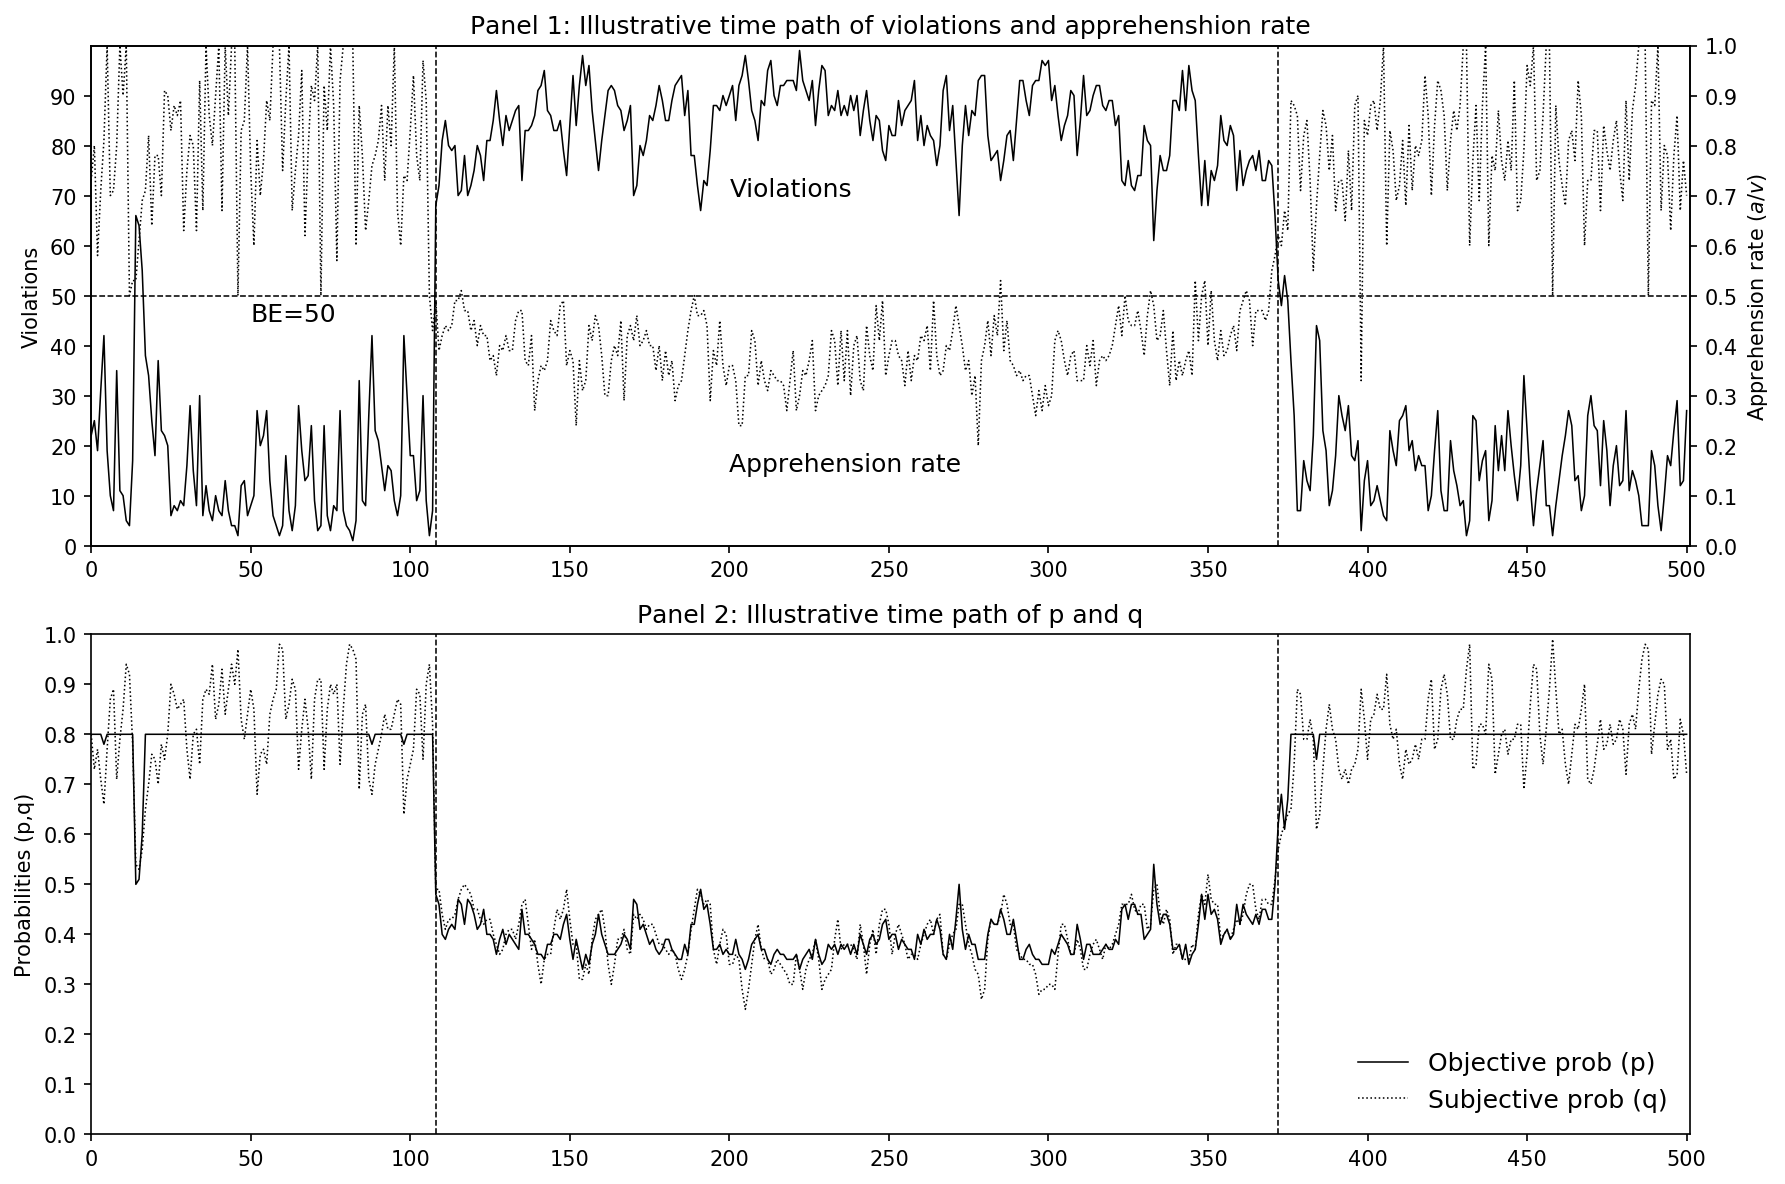

In [48]:
data = np.loadtxt(path+"fig32_data.csv", delimiter=',', dtype=float)
violations = np.zeros(len(data))
arate = np.zeros(len(data))
p = np.zeros(len(data))
q = np.zeros(len(data))
j = 0

for i in data:
    violations[j] = i[0]
    arate[j] = i[1]
    p[j] = i[2]
    q[j] = i[3]
    j = j+1

fig = plt.figure(figsize=(12,8),tight_layout=True,dpi=150)
gs = fig.add_gridspec(2, 1)
ax1 = fig.add_subplot(gs[:1, 0])
ax2 = fig.add_subplot(gs[1:, 0])

ax1.set_title('Panel 1: Illustrative time path of violations and apprehenshion rate')
ax1.set(ylabel='Violations')
ax1i = ax1.twinx()
ax1.set_xticks(np.arange(0,len(violations), 50))
ax1.set_yticks(np.arange(0,agents, 10))
ax1.set_xlim([0, len(violations)])
ax1.set_ylim([0, agents])
ax1.plot(violations, color='k', linestyle='solid',linewidth=0.75)
ax1i.plot(arate, color ='k', linestyle='dotted',linewidth=0.75)
ax1.hlines(50, xmin=0, xmax=len(violations), linestyle='dashed',linewidth=0.75) 
ax1.vlines(108, ymin=0, ymax=agents, linestyle='dashed',linewidth=0.75) 
ax1.vlines(372, ymin=0, ymax=agents, linestyle='dashed',linewidth=0.75)
ax1.text(50,45,'BE=50',color='k',fontsize='12')
ax1.text(200,70,'Violations',color='k',fontsize='12')
ax1.text(200,15,'Apprehension rate',color='k',fontsize='12')
ax1i.set(ylabel='Apprehension rate ($a/v$)')
ax1i.set_xticks(np.arange(0,len(violations), 50))
ax1i.set_yticks(np.arange(0, 1.1, 0.1))
ax1i.set_xlim([0, len(violations)])
ax1i.set_ylim([0, 1])


ax2.set_title('Panel 2: Illustrative time path of p and q')
ax2.set(ylabel='Probabilities (p, q)')
ax2.set_xticks(np.arange(0,len(p), 50))
ax2.set_yticks(np.arange(0,1.1, 0.1))
ax2.set_xlim([0, len(p)])
ax2.set_ylim([0, 1])
ax2.plot(p, color ='k', linestyle='solid',linewidth=0.75, label = 'Objective prob (p)')
ax2.plot(q, color ='k', linestyle='dotted',linewidth=0.75, label = 'Subjective prob (q)')
ax2.vlines(108, ymin=0, ymax=1, linestyle='dashed',linewidth=0.75) 
ax2.vlines(372, ymin=0, ymax=1, linestyle='dashed',linewidth=0.75)
ax2.legend(loc='lower right', fontsize=12, frameon=False)

#plt.savefig(path+);

### Figure 3.3: Persistence of violations in each regime. [2x1 panels]

In [6]:
"""
        Persistence of the attractors
            Note: 
"""
compliant_bin = 50
run_length = 2000104

chosen_r = [39,40,41,42,43]

log_ED_compliant = []
log_ED_unruly = []
frac_c = np.zeros(5)
frac_u = np.zeros(5)
mean_CB = np.zeros(5)
mean_UB = np.zeros(5)
sd_CB = np.zeros(5)
sd_UB = np.zeros(5)

criminal_opps = Criminal_opps(ḡ, σ, agents, run_length)
v, a, g, q = 0, 0, 0, 0
v, a, g, q = Simulation(criminal_opps,chosen_r[0],F,Z)
v_39 = v
state = []
compliant_v = []
unruly_v = []
tm = np.zeros((2,2))
for violation in v:
    if violation < compliant_bin:
        state.append(0)
        compliant_v.append(violation)
    elif violation >= compliant_bin:
        state.append(1)
        unruly_v.append(violation)
                
for i in range(len(state)-1):
    tm[state[i]][state[i+1]] = tm[state[i]][state[i+1]] + 1
    
prob_c = len(compliant_v)/len(state)
prob_u = len(unruly_v)/len(state)
frac_c[0] = prob_c
frac_u[0] = prob_u
prob_cc = tm[0][0]/np.sum(tm[0])
prob_cu = tm[0][1]/np.sum(tm[0])
prob_uc = tm[1][0]/np.sum(tm[1])
prob_uu = tm[1][1]/np.sum(tm[1])
if math.isnan(prob_cc):
    length_compliant = str(1)
elif prob_cc == 1:
    length_compliant = 'infinity'
else:
    length_compliant = str(math.floor(1/(1-prob_cc)))
    log_ED_compliant.append(np.log(math.floor(1/(1-prob_cc))))
if math.isnan(prob_uu):
    length_unruly = str(1)
elif prob_uu == 1:
    length_unruly = 'infinity'
else:
    length_unruly = str(math.floor(1/(1-prob_uu)))
    log_ED_unruly.append(np.log(math.floor(1/(1-prob_uu))))
if len(compliant_v) != 0:
    mode_compliant = stats.mode(compliant_v)[0][0]
    sd_compliant = str(round(np.std(compliant_v),2))
    mean_compliant = str(round(np.mean(compliant_v),2))
    mean_CB[0] = np.mean(compliant_v)
    sd_CB[0] = np.std(compliant_v)
else:
    mode_compliant = np.nan
    sd_compliant = str(np.nan)
    mean_compliant = str(np.nan)
if len(unruly_v) != 0:
    mode_unruly = stats.mode(unruly_v)[0][0]
    sd_unruly = str(round(np.std(unruly_v),2))
    mean_unruly = str(round(np.mean(unruly_v),2))
    mean_UB[0] = np.mean(unruly_v)
    sd_UB[0] = np.std(unruly_v)
else:
    mode_unruly = np.nan
    sd_unruly = str(np.nan)
    mean_unruly = str(np.nan)

criminal_opps = Criminal_opps(ḡ, σ, agents, run_length)
v, a, g, q = 0, 0, 0, 0
v, a, g, q = Simulation(criminal_opps,chosen_r[1],F,Z)
v_40 = v
state = []
compliant_v = []
unruly_v = []
tm = np.zeros((2,2))
for violation in v:
    if violation < compliant_bin:
        state.append(0)
        compliant_v.append(violation)
    elif violation >= compliant_bin:
        state.append(1)
        unruly_v.append(violation)
                
for i in range(len(state)-1):
    tm[state[i]][state[i+1]] = tm[state[i]][state[i+1]] + 1
    
prob_c = len(compliant_v)/len(state)
prob_u = len(unruly_v)/len(state)
frac_c[1] = prob_c
frac_u[1] = prob_u
prob_cc = tm[0][0]/np.sum(tm[0])
prob_cu = tm[0][1]/np.sum(tm[0])
prob_uc = tm[1][0]/np.sum(tm[1])
prob_uu = tm[1][1]/np.sum(tm[1])
if math.isnan(prob_cc):
    length_compliant = str(1)
elif prob_cc == 1:
    length_compliant = 'infinity'
else:
    length_compliant = str(math.floor(1/(1-prob_cc)))
    log_ED_compliant.append(np.log(math.floor(1/(1-prob_cc))))
if math.isnan(prob_uu):
    length_unruly = str(1)
elif prob_uu == 1:
    length_unruly = 'infinity'
else:
    length_unruly = str(math.floor(1/(1-prob_uu)))
    log_ED_unruly.append(np.log(math.floor(1/(1-prob_uu))))
if len(compliant_v) != 0:
    mode_compliant = stats.mode(compliant_v)[0][0]
    sd_compliant = str(round(np.std(compliant_v),2))
    mean_compliant = str(round(np.mean(compliant_v),2))
    mean_CB[1] = np.mean(compliant_v)
    sd_CB[1] = np.std(compliant_v)
else:
    mode_compliant = np.nan
    sd_compliant = str(np.nan)
    mean_compliant = str(np.nan)
if len(unruly_v) != 0:
    mode_unruly = stats.mode(unruly_v)[0][0]
    sd_unruly = str(round(np.std(unruly_v),2))
    mean_unruly = str(round(np.mean(unruly_v),2))
    mean_UB[1] = np.mean(unruly_v)
    sd_UB[1] = np.std(unruly_v)
else:
    mode_unruly = np.nan
    sd_unruly = str(np.nan)
    mean_unruly = str(np.nan)

criminal_opps = Criminal_opps(ḡ, σ, agents, run_length)
v, a, g, q = 0, 0, 0, 0
v, a, g, q = Simulation(criminal_opps,chosen_r[2],F,Z)
v_41 = v
state = []
compliant_v = []
unruly_v = []
tm = np.zeros((2,2))
for violation in v:
    if violation < compliant_bin:
        state.append(0)
        compliant_v.append(violation)
    elif violation >= compliant_bin:
        state.append(1)
        unruly_v.append(violation)
                
for i in range(len(state)-1):
    tm[state[i]][state[i+1]] = tm[state[i]][state[i+1]] + 1
    
prob_c = len(compliant_v)/len(state)
prob_u = len(unruly_v)/len(state)
frac_c[2] = prob_c
frac_u[2] = prob_u
prob_cc = tm[0][0]/np.sum(tm[0])
prob_cu = tm[0][1]/np.sum(tm[0])
prob_uc = tm[1][0]/np.sum(tm[1])
prob_uu = tm[1][1]/np.sum(tm[1])
if math.isnan(prob_cc):
    length_compliant = str(1)
elif prob_cc == 1:
    length_compliant = 'infinity'
else:
    length_compliant = str(math.floor(1/(1-prob_cc)))
    log_ED_compliant.append(np.log(math.floor(1/(1-prob_cc))))
if math.isnan(prob_uu):
    length_unruly = str(1)
elif prob_uu == 1:
    length_unruly = 'infinity'
else:
    length_unruly = str(math.floor(1/(1-prob_uu)))
    log_ED_unruly.append(np.log(math.floor(1/(1-prob_uu))))
if len(compliant_v) != 0:
    mode_compliant = stats.mode(compliant_v)[0][0]
    sd_compliant = str(round(np.std(compliant_v),2))
    mean_compliant = str(round(np.mean(compliant_v),2))
    mean_CB[2] = np.mean(compliant_v)
    sd_CB[2] = np.std(compliant_v)
else:
    mode_compliant = np.nan
    sd_compliant = str(np.nan)
    mean_compliant = str(np.nan)
if len(unruly_v) != 0:
    mode_unruly = stats.mode(unruly_v)[0][0]
    sd_unruly = str(round(np.std(unruly_v),2))
    mean_unruly = str(round(np.mean(unruly_v),2))
    mean_UB[2] = np.mean(unruly_v)
    sd_UB[2] = np.std(unruly_v)
else:
    mode_unruly = np.nan
    sd_unruly = str(np.nan)
    mean_unruly = str(np.nan)

criminal_opps = Criminal_opps(ḡ, σ, agents, run_length)
v, a, g, q = 0, 0, 0, 0
v, a, g, q = Simulation(criminal_opps,chosen_r[3],F,Z)
v_42 = v
state = []
compliant_v = []
unruly_v = []
tm = np.zeros((2,2))
for violation in v:
    if violation < compliant_bin:
        state.append(0)
        compliant_v.append(violation)
    elif violation >= compliant_bin:
        state.append(1)
        unruly_v.append(violation)
                
for i in range(len(state)-1):
    tm[state[i]][state[i+1]] = tm[state[i]][state[i+1]] + 1
    
prob_c = len(compliant_v)/len(state)
prob_u = len(unruly_v)/len(state)
frac_c[3] = prob_c
frac_u[3] = prob_u
prob_cc = tm[0][0]/np.sum(tm[0])
prob_cu = tm[0][1]/np.sum(tm[0])
prob_uc = tm[1][0]/np.sum(tm[1])
prob_uu = tm[1][1]/np.sum(tm[1])
if math.isnan(prob_cc):
    length_compliant = str(1)
elif prob_cc == 1:
    length_compliant = 'infinity'
else:
    length_compliant = str(math.floor(1/(1-prob_cc)))
    log_ED_compliant.append(np.log(math.floor(1/(1-prob_cc))))
if math.isnan(prob_uu):
    length_unruly = str(1)
elif prob_uu == 1:
    length_unruly = 'infinity'
else:
    length_unruly = str(math.floor(1/(1-prob_uu)))
    log_ED_unruly.append(np.log(math.floor(1/(1-prob_uu))))
if len(compliant_v) != 0:
    mode_compliant = stats.mode(compliant_v)[0][0]
    sd_compliant = str(round(np.std(compliant_v),2))
    mean_compliant = str(round(np.mean(compliant_v),2))
    mean_CB[3] = np.mean(compliant_v)
    sd_CB[3] = np.std(compliant_v)
else:
    mode_compliant = np.nan
    sd_compliant = str(np.nan)
    mean_compliant = str(np.nan)
if len(unruly_v) != 0:
    mode_unruly = stats.mode(unruly_v)[0][0]
    sd_unruly = str(round(np.std(unruly_v),2))
    mean_unruly = str(round(np.mean(unruly_v),2))
    mean_UB[3] = np.mean(unruly_v)
    sd_UB[3] = np.std(unruly_v)
else:
    mode_unruly = np.nan
    sd_unruly = str(np.nan)
    mean_unruly = str(np.nan)

criminal_opps = Criminal_opps(ḡ, σ, agents, run_length)
v, a, g, q = 0, 0, 0, 0
v, a, g, q = Simulation(criminal_opps,chosen_r[4],F,Z)
v_43 = v
state = []
compliant_v = []
unruly_v = []
tm = np.zeros((2,2))
for violation in v:
    if violation < compliant_bin:
        state.append(0)
        compliant_v.append(violation)
    elif violation >= compliant_bin:
        state.append(1)
        unruly_v.append(violation)
                
for i in range(len(state)-1):
    tm[state[i]][state[i+1]] = tm[state[i]][state[i+1]] + 1
    
prob_c = len(compliant_v)/len(state)
prob_u = len(unruly_v)/len(state)
frac_c[4] = prob_c
frac_u[4] = prob_u
prob_cc = tm[0][0]/np.sum(tm[0])
prob_cu = tm[0][1]/np.sum(tm[0])
prob_uc = tm[1][0]/np.sum(tm[1])
prob_uu = tm[1][1]/np.sum(tm[1])
if math.isnan(prob_cc):
    length_compliant = str(1)
elif prob_cc == 1:
    length_compliant = 'infinity'
else:
    length_compliant = str(math.floor(1/(1-prob_cc)))
    log_ED_compliant.append(np.log(math.floor(1/(1-prob_cc))))
if math.isnan(prob_uu):
    length_unruly = str(1)
elif prob_uu == 1:
    length_unruly = 'infinity'
else:
    length_unruly = str(math.floor(1/(1-prob_uu)))
    log_ED_unruly.append(np.log(math.floor(1/(1-prob_uu))))
if len(compliant_v) != 0:
    mode_compliant = stats.mode(compliant_v)[0][0]
    sd_compliant = str(round(np.std(compliant_v),2))
    mean_compliant = str(round(np.mean(compliant_v),2))
    mean_CB[4] = np.mean(compliant_v)
    sd_CB[4] = np.std(compliant_v)
else:
    mode_compliant = np.nan
    sd_compliant = str(np.nan)
    mean_compliant = str(np.nan)
if len(unruly_v) != 0:
    mode_unruly = stats.mode(unruly_v)[0][0]
    sd_unruly = str(round(np.std(unruly_v),2))
    mean_unruly = str(round(np.mean(unruly_v),2))
    mean_UB[4] = np.mean(unruly_v)
    sd_UB[4] = np.std(unruly_v)
else:
    mode_unruly = np.nan
    sd_unruly = str(np.nan)
    mean_unruly = str(np.nan)

### Visualization

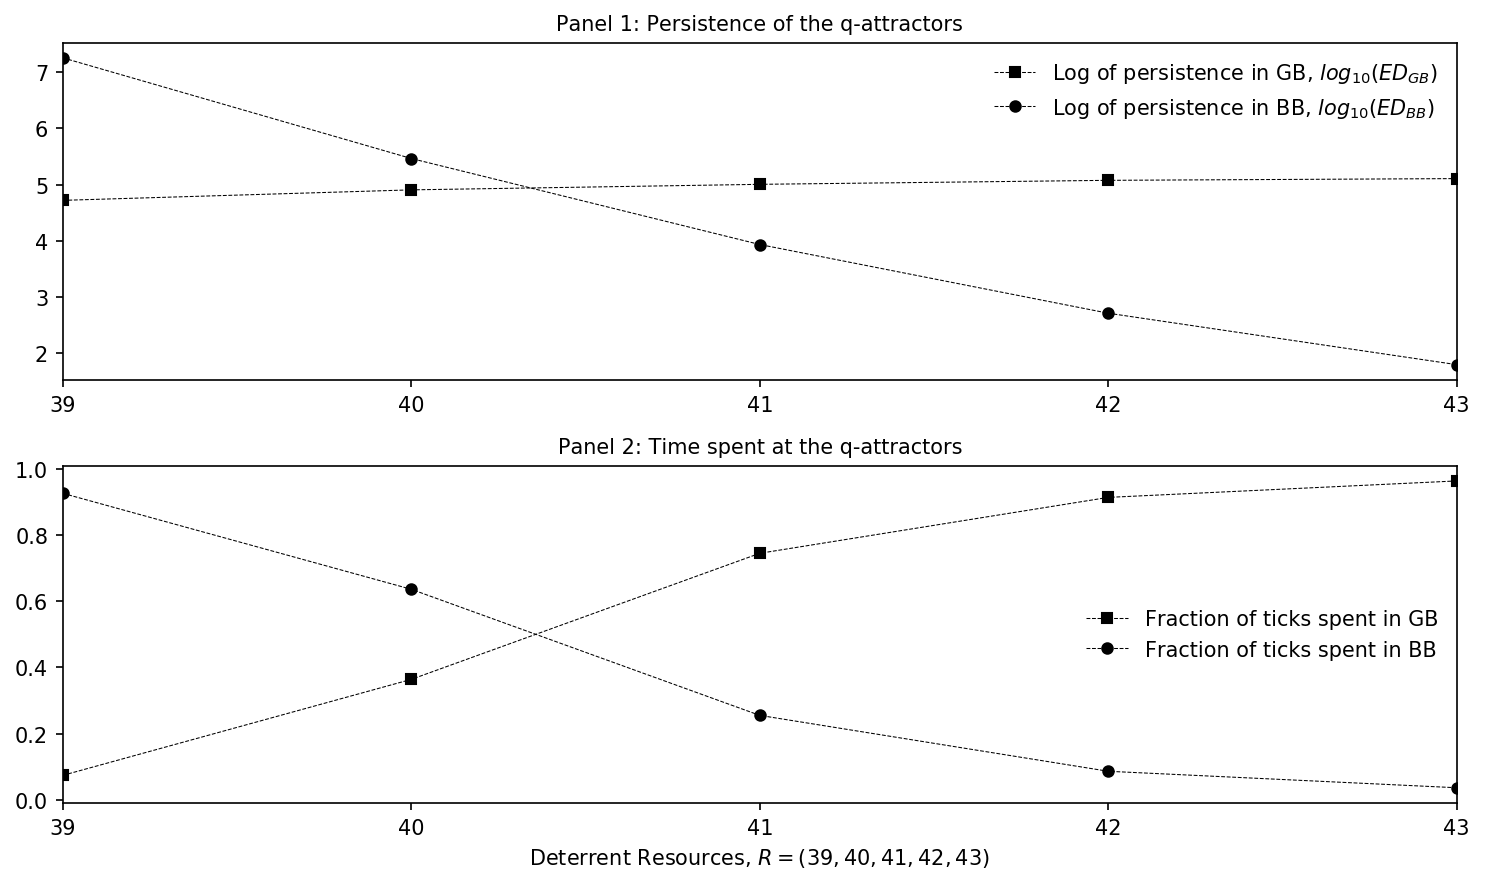

In [7]:
fig = plt.figure(figsize=(10,6),tight_layout=True,dpi=150)
labels = ['39','40','41','42','43']
x = range(0,5)

gs = fig.add_gridspec(2, 5)
ax1 = fig.add_subplot(gs[0,0:5])
ax2 = fig.add_subplot(gs[1,0:5])

ax1.set_title('Panel 1: Persistence of the q-attractors', fontsize='medium')
ax1.set_xticks(np.arange(0,5,1))
ax1.set_xlim([0,4])
ax1.set_xticklabels(labels)
ax1.plot(x, log_ED_compliant, color='k', linestyle='dashed',linewidth=0.5, marker='s', markersize=5, 
         label='Log of persistence in GB, $log_{10}(ED_{GB})$')
ax1.plot(x, log_ED_unruly, color='k', linestyle='dashed',linewidth=0.5, marker='o', markersize=5,
         label='Log of persistence in BB, $log_{10}(ED_{BB})$')
ax1.legend(loc='best', fontsize=10, frameon=False)

ax2.set_title('Panel 2: Time spent at the q-attractors', fontsize='medium')
ax2.set_xlabel('Deterrent Resources, $R=(39,40,41,42,43)$')
ax2.set_xticks(np.arange(0,5,1))
ax2.set_xlim([0,4])
ax2.set_xticklabels(labels)
ax2.plot(x, frac_c, color='k', linestyle='dashed',linewidth=0.5, marker='s', markersize=5,
         label='Fraction of ticks spent in GB')
ax2.plot(x, frac_u, color='k', linestyle='dashed',linewidth=0.5, marker='o', markersize=5,
         label='Fraction of ticks spent in BB')
ax2.legend(loc='best', fontsize=10, frameon=False)

#plt.savefig(path+);

## Figure 3.4: The dynamics of antisocial behavior for R = 39. [2x1 panels with inset]

In [56]:
run_length = 10000000
agents = 100
r,z = 39, 2
ḡ, σ = 0.6, 0.20

criminal_opps = Criminal_opps(ḡ, σ, agents, run_length)
v, a, g, q = 0, 0, 0, 0
v, a, g, q = Simulation(criminal_opps,r,F,z)

q = [i*100 for i in q]
q = np.round(q, 0)
q = [int(i) for i in q]
violations = np.zeros((agents+1,agents+1))
beliefs = np.zeros((agents+1,agents+1))

for i in range(len(v)-(100+z)):
    violations[v[i]][v[i+1]] = violations[v[i]][v[i+1]] + 1
    beliefs[q[i]][q[i+1]] = beliefs[q[i]][q[i+1]] + 1

for i in range(len(violations)):
    violations[i] = violations[i]/np.sum(violations[i])

for i in range(len(beliefs)):
    if np.sum(beliefs[i]) != 0:
        beliefs[i] = beliefs[i]/np.sum(beliefs[i])
    elif np.sum(beliefs[i]) == 0:
        beliefs[i] = beliefs[i]
    
v_range = np.arange(0,agents+1)
b_range = np.arange(0,101,1)
ex_v = np.zeros(len(violations))
ex_b = np.zeros(len(beliefs))

for i in range(len(violations)):
    ex_v[i] = np.sum(v_range*(violations[i]))
    
for i in range(len(beliefs)):
    ex_b[i] = np.sum(b_range*beliefs[i])
    
Δv = ex_v - v_range
baseline = np.arange(0, agents+1)

b1 = np.empty(agents+1)
b2 = np.empty(agents+1)
b3 = np.empty(agents+1)
b4 = np.empty(agents+1)
baseline = np.arange(0, agents+1)
x = np.zeros(agents+1)
Δv = ex_v - v_range

# plot preperation (dynamics along bottom axis)
i = np.where(np.diff(np.sign(x-Δv)))[0]
b5 = np.zeros(agents+1)
b1[0:i[0]+1] = 0
b1[i[0]+1:] = np.nan
b2[i[0]:i[1]+1] = 0
b2[:i[0]] = np.nan
b2[i[1]+1:] = np.nan
b3[i[1]+2:i[2]+1] = 0
b3[:i[1]+2] = np.nan
b3[i[2]+1:] = np.nan
b4[i[2]:] = 0
b4[:i[2]] = np.nan

### Visualization

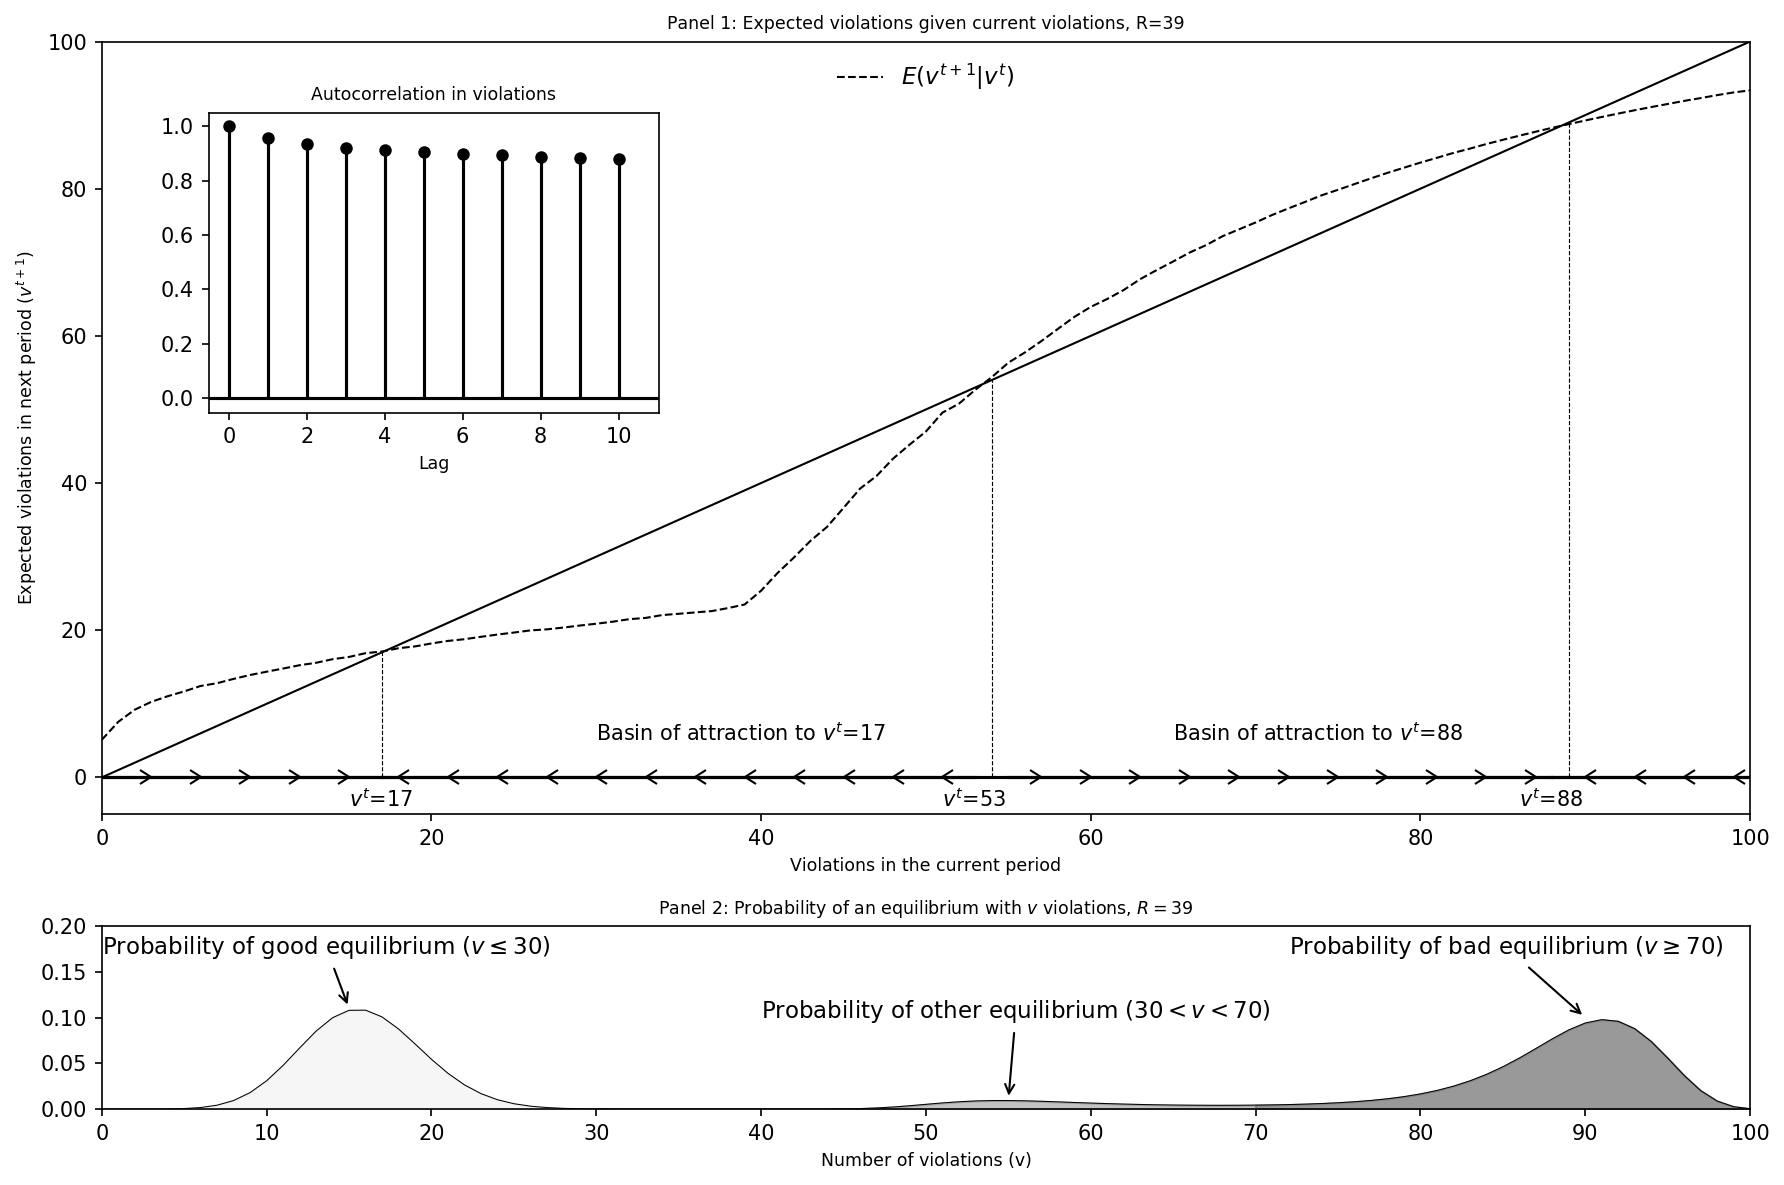

In [7]:
# plot results
prob_eq = np.load(path+'fig31_prob_eq.npy')
agents = len(prob_eq)-1
x = np.arange(0,agents+1)
x1 = np.arange(0,30)
x2 = np.arange(70,agents+1)
x3 = np.arange(30,71)

fig = plt.figure(figsize=(12,8),tight_layout=True,dpi=150)
gs = fig.add_gridspec(4, 1)
ax1 = fig.add_subplot(gs[:3, 0])
ax2 = fig.add_subplot(gs[3, 0])

left, bottom, width, height = [0.12, 0.65, 0.25, 0.25]
left1, bottom1, width1, height1 = [0.62, 0.45, 0.2, 0.2]
my_color="k"

ax1.set_title('Panel 1: Expected violations given current violations, R=39', fontsize= 'small')
ax1.set_ylabel('Expected violations in next period ($v^{t+1})$', fontsize= 'small')
ax1.set_xlabel('Violations in the current period', fontsize= 'small')
ax1.set_xlim([0,100])
ax1.set_ylim([-5,100])
ax1.plot(baseline, color='k', linewidth=1)
ax1.plot(b1, color='k', marker=5, markerfacecolor='none', markevery=3, markersize=7)
ax1.plot(b2, color='k', marker=4, markerfacecolor='none', markevery=3, markersize=7)
ax1.plot(b3, color='k', marker=5, markerfacecolor='none', markevery=3, markersize=7)
ax1.plot(b4, color='k', marker=4, markerfacecolor='none', markevery=3, markersize=7)
ax1.plot(b5, color='k')
ax1.plot(ex_v, color='k', linestyle='dashed', linewidth=1, label='$E(v^{t+1}|v^t$)')
ax1.vlines(x=i[0], ymin=0, ymax=i[0], color='k', linestyle='dashed', linewidth=0.55)
ax1.vlines(x=i[2]+1, ymin=0, ymax=i[2]+1, color='k', linestyle='dashed', linewidth=0.55)
ax1.vlines(x=i[1]+1, ymin=0, ymax=i[1]+1, color='k', linestyle='dashed', linewidth=0.55)
ax1.annotate('Basin of attraction to $v^t$='+str(i[0]), fontsize=10, xy=(30,5))
ax1.annotate('Basin of attraction to $v^t$='+str(i[2]), fontsize=10, xy=(65,5))
ax1.annotate('$v^t$='+str(i[0]), fontsize=10, xy=(i[0]-2,-4))
ax1.annotate('$v^t$='+str(i[1]), fontsize=10, xy=(i[1]-2,-4))
ax1.annotate('$v^t$='+str(i[2]), fontsize=10, xy=(i[2]-2,-4))
ax1.legend(loc='upper center', frameon=False, fontsize=11)
ax3 = fig.add_axes([left, bottom, width, height])
sm.graphics.tsa.plot_acf(v, lags=10, unbiased=True, ax=ax3)
ax3.set_title('Autocorrelation in violations', fontsize= 'small')
ax3.set_xlabel('Lag', fontsize= 'small')
for item in ax3.collections:
    #change the color of the CI 
    if type(item)==PolyCollection:
        item.set_facecolor(my_color)
    #change the color of the vertical lines
    if type(item)==LineCollection:
        item.set_color(my_color)    
#change the color of the markers/horizontal line
for item in ax3.lines:
    item.set_color(my_color)

ax2.set_title('Panel 2: Probability of an equilibrium with $v$ violations, $R=39$', fontsize= 'small')
ax2.set_xlabel('Number of violations (v)', fontsize= 'small')
ax2.yaxis.label.set_size(11)
ax2.set_xticks(np.arange(0,agents+10,10))
ax2.set_yticks(np.arange(0, 0.25,.05))
ax2.set_xlim([0, agents])
ax2.set_ylim([0, 0.20])
ax2.plot(x, prob_eq[39], color='k', linestyle='solid',linewidth=0.5)
ax2.fill_between(x1, prob_eq[39,:30], color='lightgray', alpha=0.2)
ax2.fill_between(x3, prob_eq[39,30:71], color='dimgray', alpha=0.4)
ax2.fill_between(x2, prob_eq[39,70:], color='gray', alpha=0.8)
ax2.annotate('Probability of bad equilibrium ($v \geq 70$)', xy=(90, .10), xytext=(72, .17), fontsize=11,
            arrowprops={'arrowstyle':'->'})
ax2.annotate('Probability of good equilibrium ($v \leq 30$)', xy=(15, .11), xytext=(0, .17), fontsize=11,
            arrowprops={'arrowstyle':'->'})
ax2.annotate('Probability of other equilibrium ($30 < v < 70$)', xy=(55, .01), xytext=(40, .10), fontsize=11,
            arrowprops={'arrowstyle':'->'})

#plt.savefig(path+);

## Figure 3.5: E(v|R) for baseline parameterization, the “Cliff of Positive Feedback.” [2x1 panels]

In [17]:
"""
        Visualizing the cliff
            Note: 
"""
agents, Z = 100, 2
R_low, R_high = 0, agents+1

v_μ = np.zeros(R_high-R_low)
g_μ = np.zeros(R_high-R_low)
a_μ = np.zeros(R_high-R_low)
v_σ = np.zeros(R_high-R_low)
v_m = np.zeros(R_high-R_low)
ϕ = np.zeros(R_high-R_low)

for r in range(R_low,R_high):
    converged, passed = False, 0
    DD1 = np.zeros(agents+1)
    DD2 = np.zeros(agents+1)
    criminal_opps = Criminal_opps(ḡ,σ,agents,block)
    v_t, a_t, g_t = Simulation(criminal_opps,r,F,Z)
    v, a, g = 0, 0, 0
    v = np.append(v, v_t)
    a = np.append(a, a_t)
    g = np.append(g, g_t)
    for i in v:
        DD1[i] = DD1[i] + 1
    while not converged:
        criminal_opps = Criminal_opps(ḡ,σ,agents,block)
        v_t, a_t, g_t = Simulation(criminal_opps,r,F,Z)
        v = np.append(v, v_t)
        a = np.append(a, a_t)
        g = np.append(g, g_t)
        for i in v:
            DD2[i] = DD2[i] + 1    
        if np.abs(np.sum((DD2/np.sum(DD2)) - (DD1/np.sum(DD1)))) < C:
            passed = passed + 1
            if passed > checks:
                converged = True
        DD1 = DD2
    DD1 = DD1/np.sum(DD1)
    v_μ[r] = np.mean(v)
    a_μ[r] = np.mean(a)
    g_μ[r] = np.mean(g)
    v_σ[r] = np.std(v)
    v_m[r] = stats.mode(v,axis=None)[0][0]
    gp = -1
    eqn = 0
    while eqn < v_μ[r]:
        gp = gp + 0.0001
        eqn= agents*norm.cdf(gp,ḡ,σ)
    ϕ[r] = norm.pdf(gp,ḡ,σ)
    
np.save(path+'fig52_mean_v.npy', v_μ)   
np.save(path+'fig52_mean_a.npy', a_μ)   
np.save(path+'fig52_mean_g.npy', g_μ)
np.save(path+'fig52_std_v.npy', v_σ)
np.save(path+'fig52_mode_v.npy', v_m)
np.save(path+'fig52_pivot_g.npy', ϕ)

### Visualization

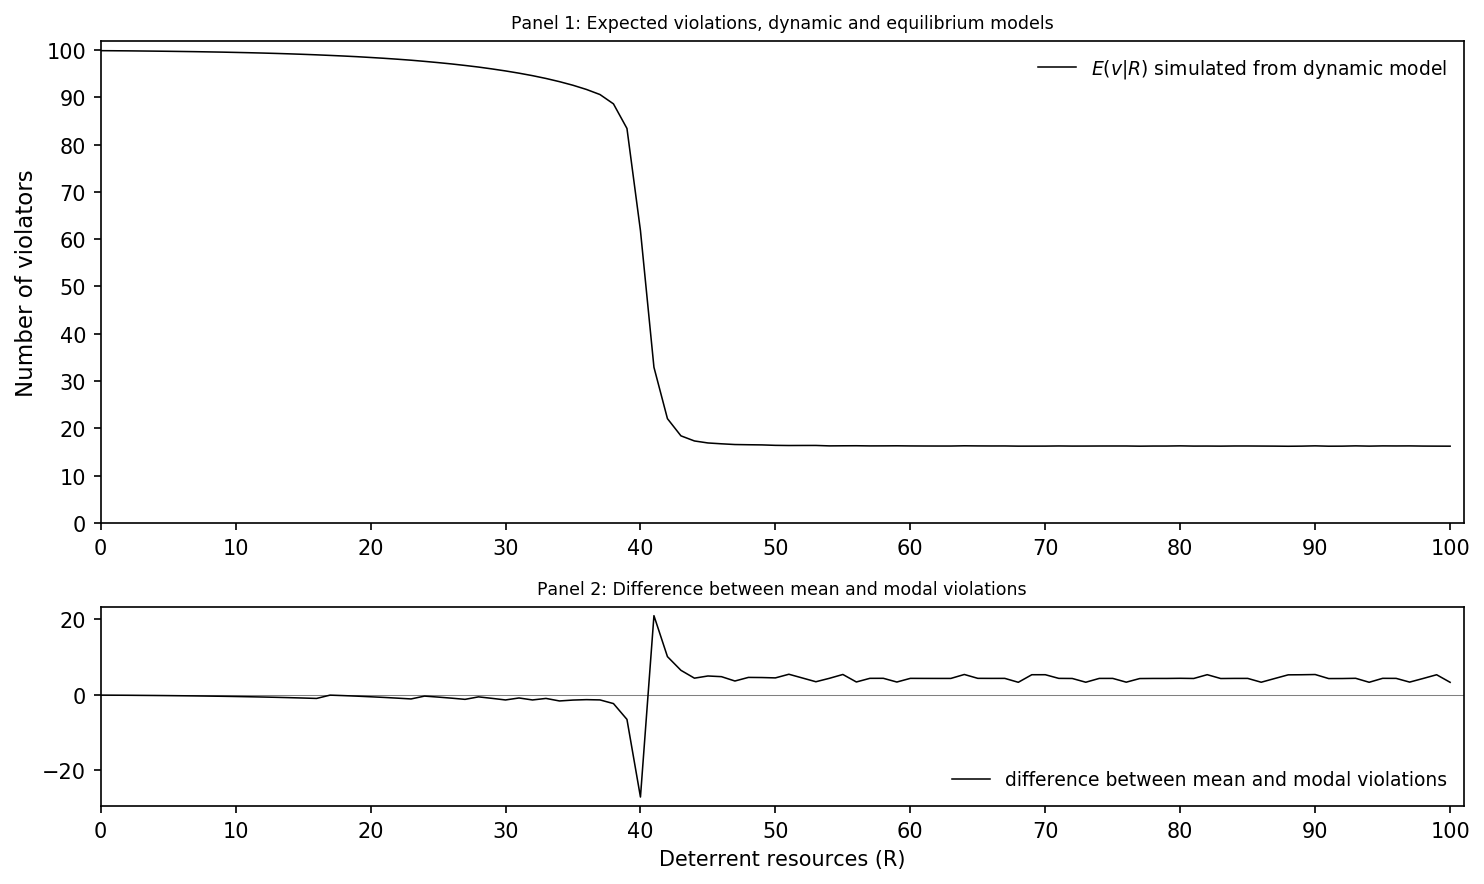

In [6]:
v_μ = np.load(path+'fig52_mean_v.npy')   
v_m = np.load(path+'fig52_mode_v.npy')
ex_eq_v = np.load(path+'fig31_ex_eq_v.npy')
Δ = v_μ - v_m
x = np.arange(R_low,len(v_μ))

fig = plt.figure(figsize=(10,6),tight_layout=True,dpi=150)
gs = fig.add_gridspec(3, 1)
ax1 = fig.add_subplot(gs[:2, 0])
ax2 = fig.add_subplot(gs[2, 0])
plt.xlabel('Deterrent resources (R)', fontsize= 'medium')
ax1.set_title('Panel 1: Expected violations, dynamic and equilibrium models', fontsize= 'small')
ax1.set(ylabel='Number of violators')
ax1.yaxis.label.set_size(11)
ax1.set_xticks(np.arange(0,R_high,10))
ax1.set_yticks(np.arange(0, R_high+2,10))
ax1.set_xlim([R_low, R_high])
ax1.set_ylim([0, agents+2])
ax2.set_title(r'Panel 2: Difference between mean and modal violations', fontsize= 'small')
ax2.set_xticks(np.arange(0,R_high,10))
ax2.set_xlim([R_low, R_high])
ax2.yaxis.label.set_size(11)
ax1.plot(x, v_μ, color='k', linestyle='solid',linewidth=0.75, label=r'$E(v|R)$ simulated from dynamic model')
#ax1.plot(x, ex_eq_v, color='k', linestyle=':',linewidth=0.75, label='$E(v|R)$ calculated from equilbrium model')
ax2.axhline(y=0, color='grey', linestyle='solid', linewidth=0.5)
ax2.plot(x, Δ, color='k', linestyle='solid',linewidth=0.75, label='difference between mean and modal violations')
ax1.legend(loc='best', fontsize=9, frameon=False)
ax2.legend(loc='lower right', fontsize=9, frameon=False)

#plt.savefig(path+);